# Verification of SOL 106's Nonlinear Buckling Method

In this notebook we want to perform a verification study on SOL 106's nonlinear buckling method. This study is inspired by the verification of the nonlinear buckling method presented by [Lee & Herting (1985)](https://onlinelibrary.wiley.com/doi/pdf/10.1002/nme.1620211016). In their paper, the authors mentioned that the nonlinear buckling method should be applicable to linear problems because linear buckling is a special case of nonlinear buckling. For this reason they tested the nonlinear buckling method on Euler's column, analogously to what we did in our [first notebook](01_Buckling_Analysis_of_Euler_Column.ipynb).

Since in our [last notebook](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb) we found out that the box beam appears to behave linearly up to the buckling load predicted by SOL 105, here we follow the same reasoning of Lee & Herting and apply the nonlinear buckling method to verify whether we are able to reproduce the results of the linear buckling analysis in the linear region of the structural response. We will also test the nonlinear buckling method beyond the buckling load predicted by SOL 105 to observe how the method behaves.

* [Problem definition](#problem)
* [Setup of the numerical model](#numerical-model)
* [Nonlinear buckling method verification](#verification)
* [Tangent stiffness matrix assessment](#tangent-stiffness-matrix)
* [Conclusion](#conclusion)

## Problem definition <a name="problem"></a>

***

We consider the same box beam model that we used in our [last notebook](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb), that is to say with a rigid tip section and a concentrated load applied at the center of such section.

![Concentrated tip load.](resources/04_BoxBeamConcentratedLoad.svg "Concentrated tip load.")

In [1]:
AR = 9.0  # aspect ratio - 2*b/w (the length of the box beam corresponds to half the span of the CRM wing)
w = 1e3  # width [mm]
l = AR * w / 2  # length [mm]
non_dimensional_height = 0.2  # h/w
h = w * non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1 / 50  # t/h
t = h * non_dimensional_thickness  # shell thickness [mm]
print(
    f"""
Box beam dimensions:
- width: {w/1e3:.1f} m
- length: {l/1e3:.1f} m
- height: {h/1e3:.1f} m
- wall thickness: {t:.1f} mm"""
)


Box beam dimensions:
- width: 1.0 m
- length: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


In [2]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

## Setup of the numerical model <a name="numerical-model"></a>

***

We discretize the geometry of our box beam into quadrilateral elements using the function `mesh_box_beam` from the `box_beam_utils` module. For that we use a target shell element edge length of 60 mm, following the results of our previous [mesh convergence study](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#mesh-convergence).

In [3]:
from resources import box_beam_utils

shell_element_length = 59.9  # [mm]
box_beam_mesh = box_beam_utils.mesh_box_beam(
    width=w, length=l, height=h, element_length=shell_element_length
)
nodes_coordinates_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

Then we create a base bdf input using the function `create_base_bdf_input` and we print a summary of the bulk data cards defined in the resulting `BDF` object.

In [4]:
box_beam_bdf_input = box_beam_utils.create_base_bdf_input(
    young_modulus=E,
    poisson_ratio=nu,
    density=rho,
    shell_thickness=t,
    nodes_xyz_array=nodes_coordinates_array,
    nodes_connectivity_matrix=nodes_connectivity_matrix,
)
print(box_beam_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 3388

bdf.elements: 0
  CQUAD4   : 3344

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Now we need to make the tip section of the box beam rigid and apply a concentrated load. For this purpose we add a master node at the center of the tip section, add a `RBE2` element to make the section rigid and add a `FORCE` card to define a force along the $z$-axis applied at the master node.

In [5]:
import numpy as np

# Add master node of tip section
master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf_input.add_grid(master_node_id, [w / 2, l, 0.0])

# Add RBE2 element to make tip section rigid
nodes_ids = np.arange(
    1, np.size(nodes_coordinates_array, 0) + 1
)  # find ids of all nodes
tip_nodes_ids = nodes_ids[
    nodes_coordinates_array[:, 1] == l
]  # find ids of nodes at tip section
rbe2_eid = len(box_beam_bdf_input.elements) + 1
box_beam_bdf_input.add_rbe2(rbe2_eid, master_node_id, "123456", tip_nodes_ids)

# Add concentrated force
force_set_id = 11
concentrated_force_magnitude = 1.0
concentrated_force_direction = [0.0, 0.0, 1.0]
box_beam_bdf_input.add_force(
    sid=force_set_id,
    node=master_node_id,
    mag=concentrated_force_magnitude,
    xyz=concentrated_force_direction,
)

FORCE         11    3389              1.      0.      0.      1.

## Nonlinear buckling method verification <a name="verification"></a>

***

Given the linear behavior observed for our box beam in our last notebook, with this analysis we want to verify whether we are able to obtain the same buckling load predicted by SOL 105 with SOL 106's nonlinear buckling method. We are going to test this hypothesis for different applied loads ranging from a fraction of the buckling load predicted by SOL 105 to twice its value, as we are also interested in checking the results of the nonlinear buckling method beyond the linear region of the structural response.

In order to execute this sweep, we define the function `run_nonlinear_buckling_method_sweep` in an analogous way as we did in our [fourth notebook](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#disrtibuted-load-flexible-tip).

In [6]:
from resources import pynastran_utils
import os
from pyNastran.op2.op2 import read_op2


# Function to set up and run the nonlinear analysis with the nonlinear buckling methods for a sequence of applied loads
def run_nonlinear_buckling_method_sweep(
    bdf_input, load_magnitudes, directory_path, input_filename, run_flag=True
):
    # Set up nonlinear analysis with arc-length method
    pynastran_utils.set_up_arc_length_method(
        bdf=bdf_input,
        ninc=100,
        max_iter=25,
        conv="PUV",
        eps_p=1e-3,
        eps_u=1e-3,
        max_bisect=10,
        minalr=0.01,
        maxalr=1.0001,
        desiter=5,
        maxinc=1000,
    )
    # Define parameters for buckling analysis
    bdf_input.add_param(
        "BUCKLE", [2]
    )  # PARAM card to request nonlinear buckling analysis
    eigrl_sid = force_set_id + 1
    bdf_input.add_eigrl(
        sid=eigrl_sid, v1=0.0, nd=1
    )  # calculate only the first positive eigenvalue with the Lanczos method
    bdf_input.case_control_deck.subcases[0].add_integer_type("METHOD", eigrl_sid)
    # Create the LOAD cards and corresponding subcases for each input load magnitude
    for i, scale_factor in enumerate(load_magnitudes):
        load_set_id = 21 + i
        bdf_input.add_load(
            sid=load_set_id,
            scale=1.0,
            scale_factors=[scale_factor],
            load_ids=[force_set_id],
        )  # create LOAD card
        pynastran_utils.create_static_load_subcase(
            bdf=bdf_input, subcase_id=i + 1, load_set_id=load_set_id
        )  # create subcase
    # Run analysis
    pynastran_utils.run_analysis(
        directory_path=directory_path,
        bdf=bdf_input,
        filename=input_filename,
        run_flag=run_flag,
    )
    # Read op2 file
    op2_path = os.path.join(directory_path, input_filename + ".op2")
    op2 = read_op2(op2_filename=op2_path, load_geometry=True, debug=None)
    # Return op2 object
    return op2

We recall the buckling load predicted by SOL 105 for our model (see [notebook 4](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#mesh-convergence)) and we define 11 load magnitudes equally spaced between 0 and twice the linear buckling load. We discard the load case with null magnitude and we keep the other 10 load cases.

In [7]:
linear_buckling_load = 1654.0  # [N]
applied_load_magnitudes = np.linspace(0, 2 * linear_buckling_load, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f"Applied loads [N]: {applied_load_magnitudes}")

Applied loads [N]: [ 331.  662.  992. 1323. 1654. 1985. 2316. 2646. 2977. 3308.]


Let's define the analysis folder and run our first nonlinear buckling load sweep.

In [8]:
import os  # import operating system module

# Define name of analysis directory
analysis_directory_name = "06_Verification_of_SOL_106_Nonlinear_Buckling_Method"
analysis_directory_path = os.path.join(os.getcwd(), "analyses", analysis_directory_name)

# Run analysis
input_name = "nonlinear_buckling_verification"
sol_106_op2 = run_nonlinear_buckling_method_sweep(
    box_beam_bdf_input.__deepcopy__({}),
    applied_load_magnitudes,
    analysis_directory_path,
    input_name,
    run_flag=False,
)

Nastran job nonlinear_buckling_verification.bdf completed
Wall time: 914.0 s


Analogously to what we did in our fourth notebook, we define the function `plot_buckling_loads` to plot the buckling load predicted by SOL 106, $P_\text{SOL 106}$, and the critical buckling factor $\alpha$ against the applied load $P$. Both loads are nondimensionalized with the linear buckling load, $P_\text{SOL 105}$. Subsequently, we read the nonlinear buckling loads and the critical buckling factors from the f06 file using the function `read_nonlinear_buckling_load_from_f06` and we plot the results of our analysis.

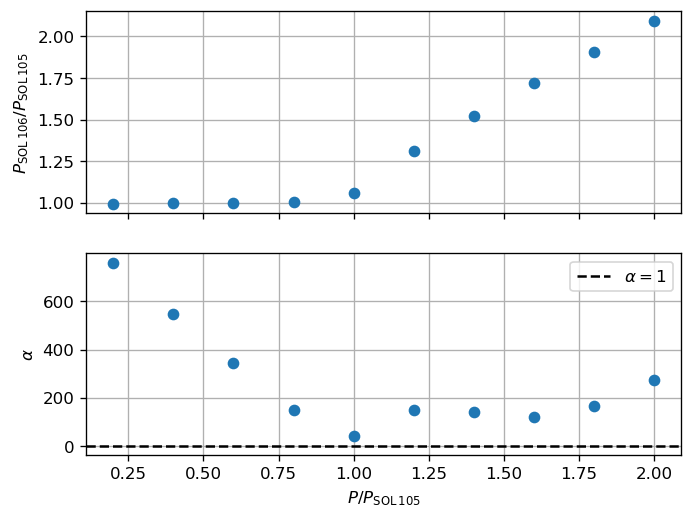

In [9]:
import matplotlib.pyplot as plt


# Function to plot SOL 106 buckling loads and critical buckling factors against applied loads
def plot_buckling_loads(
    applied_loads, sol_105_buckling_load, sol_106_buckling_loads, alphas
):
    _, axs = plt.subplots(nrows=2, ncols=1, sharex="all")  # figure with 2 subplots
    axs[0].plot(
        applied_loads / sol_105_buckling_load,
        sol_106_buckling_loads / sol_105_buckling_load,
        "o",
    )  # buckling loads vs applied loads
    axs[1].plot(
        applied_loads / sol_105_buckling_load, alphas, "o"
    )  # critical buckling factors vs applied loads
    axs[1].axhline(
        y=1, color="k", ls="--", label="$\\alpha=1$"
    )  # alpha=1 reference line
    # Set plot appearance
    axs[0].set_ylabel("$P_\mathrm{SOL\,106}/P_\mathrm{SOL\,105}$")
    axs[0].grid(visible=True)
    axs[1].set_ylabel("$\\alpha$")
    axs[1].grid(visible=True)
    axs[1].legend()
    axs[1].set_xlabel("$P/P_\mathrm{SOL\,105}$")
    plt.show()


# Set default dpi of figures
plt.rcParams["figure.dpi"] = 120

# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_load_vectors, critical_buckling_factors = (
    pynastran_utils.read_nonlinear_buckling_load_from_f06(
        f06_filepath=os.path.join(analysis_directory_path, input_name + ".f06"),
        op2=sol_106_op2,
    )
)  # read buckling loads and critical buckling factors from f06 file
nonlinear_buckling_loads = np.linalg.norm(
    np.sum(nonlinear_buckling_load_vectors[:, :, 0:3], axis=1), axis=1
)  # calculate the norm of the nonlinear buckling load vector for each subcase

# Plot results
plot_buckling_loads(
    applied_load_magnitudes,
    linear_buckling_load,
    nonlinear_buckling_loads,
    critical_buckling_factors,
)

The results show that the nonlinear buckling method predicts the same buckling load of SOL 105 for $P/P_\text{SOL 105}<1$, confirming that in the linear regime the nonlinear buckling method is able to predict the same buckling load of SOL 105. For $P/P_\text{SOL 105}\geq1$ the nonlinear buckling method predicts a larger buckling load than SOL 105 and we observe a nearly linear relation between the applied load and the nonlinear buckling load.

In our [last notebook](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb#sensitivity), we observed that the deformation of the box beam at $P/P_\text{SOL 105}=1$ featured a buckled-like shape of the top skin, suggesting that some nonlinear effects may come into play and affect the structural response. As a consequence, it is possible that the difference between $P_\text{SOL 106}$ and $P_\text{SOL 105}$ for $P/P_\text{SOL 105}\geq1$ is caused by this nonlinearity. On the other hand, it is not immediately clear why the nonlinear buckling method predicts the seemingly linear behavior observed between nonlinear buckling load and applied load.

As far as the critical buckling factor $\alpha$ is concerned, we observe initially large values with a linear decreasing trend for $P/P_\text{SOL 105}<1$, with a minimum at $P/P_\text{SOL 105}=1$. This behavior makes sense: the applied load is initially very far from the buckling load predicted by SOL 106 and it gradually gets closer. As a consequence $\alpha$ is initially very large and it gradually decreases. However, all values of $\alpha$ are one order of magnitude larger than 1 or more.

For $P/P_\text{SOL 105}>1$, $\alpha$ appears to first decrease slightly and then to increase at a larger rate, as shown in the zoomed version of the plot below. Considering that in this range the nonlinear buckling method predicts a nearly linear relationship between the nonlinear buckling load and the applied load, it is not obvious to explain these results.

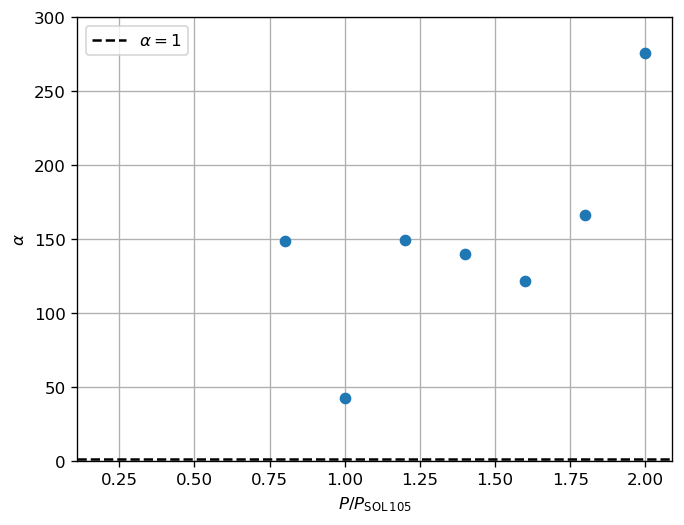

In [10]:
ax = plt.subplot()
ax.plot(
    applied_load_magnitudes / linear_buckling_load, critical_buckling_factors, "o"
)  # critical buckling factors vs applied loads
ax.axhline(y=1, color="k", ls="--", label="$\\alpha=1$")  # alpha=1 reference line
ax.set_xlabel("$P/P_\mathrm{SOL\,105}$")
ax.set_ylabel("$\\alpha$")
ax.grid(visible=True)
ax.set_ylim([0, 300])  # set y-axis limits to zoom in on the plot
ax.legend()
plt.show()


Let's plot the equilibrium diagram of the structure in terms of applied load vs tip displacement $u_{z, tip}$. We read the load and displacement history from the `OP2` object using the function `read_load_displacement_history_from_op2`, collect together the applied loads and the tip displacements from all subcases and make the plot. The tip displacement is expressed as a percentage of the length $l$ of the box beam.

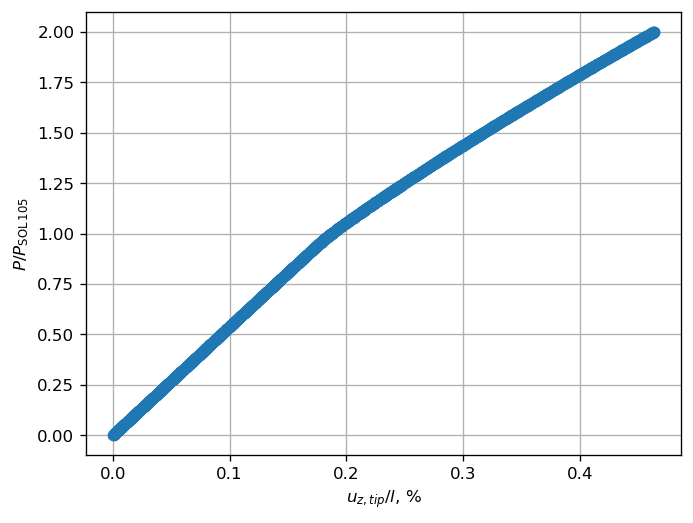

In [11]:
# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2=sol_106_op2, node_ids=[master_node_id]
)

# Collect load and displacement history
load_component_index = 2  # select z-axis component of the load
displacement_component_index = 2  # select z-axis component of the displacement
load_history = np.concatenate(
    [loads[subcase_id][:, load_component_index] for subcase_id in loads]
)  # concatenate applied load arrays of all subcases
displacement_history = np.concatenate(
    [
        displacements[master_node_id][subcase_id][:, displacement_component_index]
        for subcase_id in loads
    ]
)  # concatenate displacement arrays of all subcases

# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacement_history / l * 100, load_history / linear_buckling_load, "o")
plt.xlabel("$u_{z, tip}/l$, %")
plt.ylabel("$P/P_\mathrm{SOL\,105}$")
plt.grid()
plt.show()

We observe a change in the slope of the load-displacement diagram approximately for $P/P_\text{SOL 105}=1$. This can be most probably ascribed to the buckled-like deformation of the top skin that we observed in our [last notebook](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb#sensitivity).

Let's plot the deformation of the box beam at the end of the analysis ($P/P_\text{SOL 105}=2$) to verify the state of the top skin.

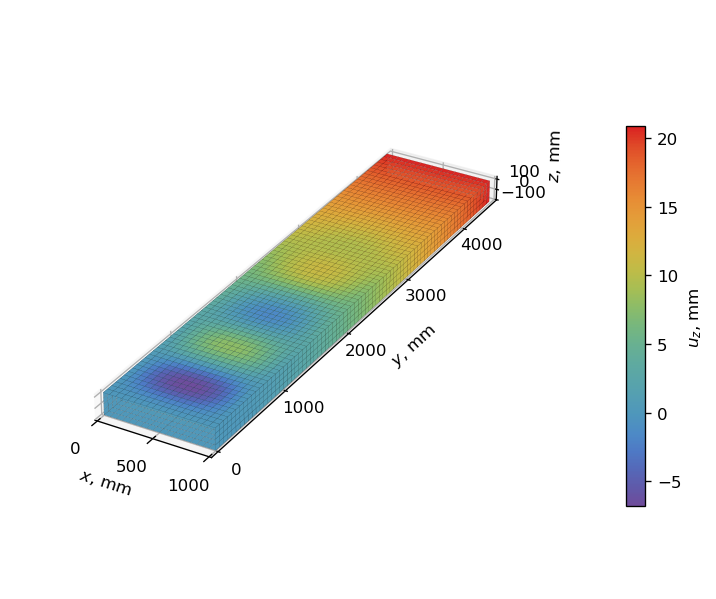

In [12]:
from resources import plot_utils  # module with functions to plot deformed shapes

valid_subcase_ids = [
    subcase_id
    for subcase_id in sol_106_op2.load_vectors
    if hasattr(sol_106_op2.load_vectors[subcase_id], "lftsfqs")
]  # find ids of the subcases associated with static nonlinear analysis
_, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2,
    subcase_id=valid_subcase_ids[-1],
    displacement_component="tz",
    length_unit="mm",
)  # plot static deformation at the end of the last subcase
ax.locator_params(axis="x", nbins=3)  # set number of x-axis ticks
ax.locator_params(axis="z", nbins=2)  # set number of z-axis ticks
ax.tick_params(axis="y", which="major", pad=20)  # set distance of y-axis tick labels
ax.tick_params(axis="z", which="major", pad=6)  # set distance of z-axis tick labels
ax.yaxis.labelpad = 60  # set distance of y-axis label
ax.zaxis.labelpad = 10  # set distance of z-axis label
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, 0.66))  # decrease colorbar size
cbar.ax.set_position(
    cbar.ax.get_position().translated(0, 0.14)
)  # move colorbar upwards
plt.show()  # show plot

We can see that the top skin develops a clear buckled-like shape for $P/P_\text{SOL 105}=2$. As a consequence we can conclude that the nonlinearity observed in the load-displacement diagram must be caused by the deformation state of the top skin for $P/P_\text{SOL 105}\geq1$, which affects the global stiffness of the box beam.

Given the difficult interpretation of the nonlinear buckling method results for $P/P_\text{SOL 105}\geq1$ let's repeat our analysis for a set of applied loads more zoomed around $P/P_\text{SOL 105}=1$. We define 10 applied loads ranging from $P/P_\text{SOL 105}=0.75$ to $P/P_\text{SOL 105}=1.25$, run the analysis and plot the nonlinear buckling loads and the critical bukling factors against the applied loads.

Applied loads [N]: [1240. 1332. 1424. 1516. 1608. 1700. 1792. 1884. 1976. 2068.]
Nastran job nonlinear_buckling_verification_zoomed.bdf completed
Wall time: 971.0 s


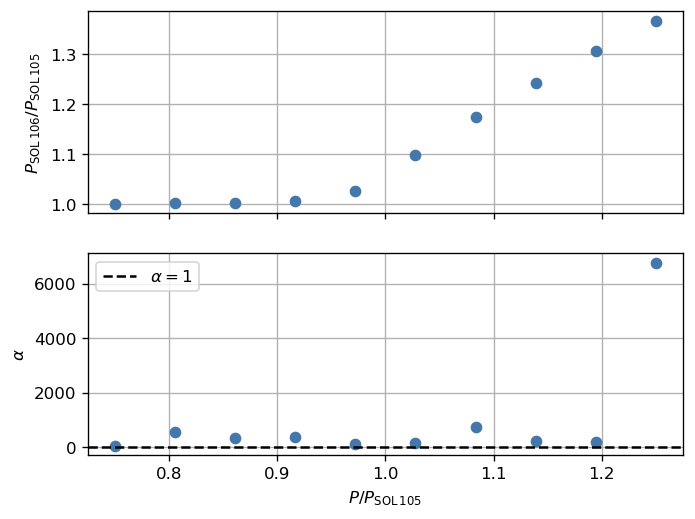

In [13]:
# Define applied loads
applied_load_magnitudes = np.linspace(
    0.75 * linear_buckling_load, 1.25 * linear_buckling_load, 10
)
print(f"Applied loads [N]: {applied_load_magnitudes}")

# Run analysis
input_name = "nonlinear_buckling_verification_zoomed"
sol_106_op2 = run_nonlinear_buckling_method_sweep(
    box_beam_bdf_input.__deepcopy__({}),
    applied_load_magnitudes,
    analysis_directory_path,
    input_name,
    run_flag=False,
)

# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_load_vectors, critical_buckling_factors = (
    pynastran_utils.read_nonlinear_buckling_load_from_f06(
        f06_filepath=os.path.join(analysis_directory_path, input_name + ".f06"),
        op2=sol_106_op2,
    )
)  # read buckling loads and critical buckling factors from f06 file
nonlinear_buckling_loads = np.linalg.norm(
    np.sum(nonlinear_buckling_load_vectors[:, :, 0:3], axis=1), axis=1
)  # calculate the norm of the nonlinear buckling load vector for each subcase

# Plot SOL 106 buckling loads and critical buckling factors
plot_buckling_loads(
    applied_load_magnitudes,
    linear_buckling_load,
    nonlinear_buckling_loads,
    critical_buckling_factors,
)

Let's zoom in the critical buckling factor plot to better observe how close is $\alpha$ to 1.

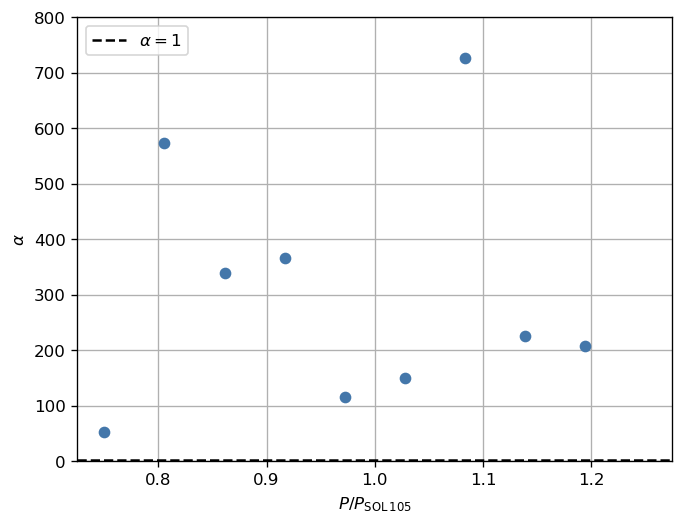

In [14]:
ax = plt.subplot()
ax.plot(
    applied_load_magnitudes / linear_buckling_load, critical_buckling_factors, "o"
)  # critical buckling factors vs applied loads
ax.axhline(y=1, color="k", ls="--", label="$\\alpha=1$")  # alpha=1 reference line
ax.set_xlabel("$P/P_\mathrm{SOL\,105}$")
ax.set_ylabel("$\\alpha$")
ax.grid(visible=True)
ax.set_ylim([0, 800])  # set y-axis limits to zoom in on the plot
ax.legend()
plt.show()

These results confirm the ability of the nonlinear buckling method to predict the same buckling load of the linear analysis for $P/P_\text{SOL 105}<1$ and suggests a slightly more gradual change transition to the seemingly linear relation for $P/P_\text{SOL 105}\geq1$. However, the most interesting resutls are obtained for the critical buckling factor $\alpha$. We can see that the smallest value is obtained for the first applied load, and for all other applied loads $\alpha$ is larger. Why does this happen? This can be ascribed to the fact that the load applied in the first subcase is much larger than the total incremental load applied in the second subcase. As a consequence, the last load increment vector $\boldsymbol{\Delta P}$ in the first subcase is much larger than the one in the second subcase and it requires a smaller $\alpha$ to achieve the same critical buckling load.

These results suggest that the hard threshold of $\alpha=1$ suggested by [Lee & Herting (1985)](https://onlinelibrary.wiley.com/doi/pdf/10.1002/nme.1620211016) to assess whether the predicted buckling point is close to the last converged solution (and consequently whether the prediction can be deemed reliable) is actually arbitrary. In fact, we can see that the calculated value of $\alpha$ is strongly dependent on both the total incremental load applied between successive subcases and, consequently, the latter should be taken into consideration when interpreting the value of $\alpha$.

Going back to the buckling load results, how can we interpret those? We can try to give an explanation by taking inspiration from Euler's column. In our [second notebook](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb) we observed the "break" of the supercritical pitchfork bifurcation when we applied a compression load with some eccentricity. In an analogous way, it is possible that under a bending load the bifurcation potentially corresponding to the critical buckling load of the box beam breaks down and we are left with an equilibrium path that is analogous to a broken supercritical pitchfork. In order to verify this, we need to repeat our nonlinear analysis monitoring the lowest eigenvalue $\lambda$ of the tangent stiffness matrix for each converged iteration.

## Tangent stiffness matrix assessment <a name="tangent-stiffness-matrix"></a>

***

Let's create a copy of the original base bdf input, set up the nonlinear analysis with the arc-length method, define the parameters for the calculation of the lowest eigenvalue $\lambda$ of the tangent stiffness matrix, set the applied load magnitude to twice the buckling load predicted by SOL 105 and run the analysis.

In [15]:
# Create deep copy of bdf object and set up nonlinear analysis with the arc-length method
box_beam_tangent_stiffness_matrix_input = box_beam_bdf_input.__deepcopy__({})
pynastran_utils.set_up_arc_length_method(
    bdf=box_beam_tangent_stiffness_matrix_input,
    ninc=100,
    max_iter=25,
    conv="PUV",
    eps_p=1e-3,
    eps_u=1e-3,
    max_bisect=10,
    minalr=0.01,
    maxalr=1.0001,
    desiter=5,
    maxinc=1000,
)

# Define parameters for the calculation of the lowest eigenvalue of the tangent stiffness matrix
box_beam_tangent_stiffness_matrix_input.add_param(
    "BUCKLE", [2]
)  # request nonlinear buckling method
eigrl_set_id = force_set_id + 1  # set identification number of EIGRL card
box_beam_tangent_stiffness_matrix_input.add_eigrl(
    sid=eigrl_set_id, v1=0.0, nd=1
)  # calculate only the first positive eigenvalue
box_beam_tangent_stiffness_matrix_input.case_control_deck.subcases[0].add_integer_type(
    "METHOD", eigrl_set_id
)  # add EIGRL card id to case control deck
box_beam_tangent_stiffness_matrix_input.executive_control_lines[1:1] = [
    "include '"
    + os.path.join(os.pardir, os.pardir, "resources", "kllrh_eigenvalues.dmap")
    + "'"
]  # include DMAP sequence

# Define force magnitude and create subcase
box_beam_tangent_stiffness_matrix_input.loads[force_set_id][0].mag = (
    linear_buckling_load * 2
)
first_subcase_id = 1
pynastran_utils.create_static_load_subcase(
    bdf=box_beam_tangent_stiffness_matrix_input,
    subcase_id=first_subcase_id,
    load_set_id=force_set_id,
)

# Run analysis
input_name = "tangent_stiffness_matrix"
pynastran_utils.run_analysis(
    directory_path=analysis_directory_path,
    bdf=box_beam_tangent_stiffness_matrix_input,
    filename=input_name,
    run_flag=False,
)

Nastran job tangent_stiffness_matrix.bdf completed
Wall time: 206.0 s


Now we can read the load history from the op2 file, the lowest eigenvalues from the f06 file and plot the latter against the former.

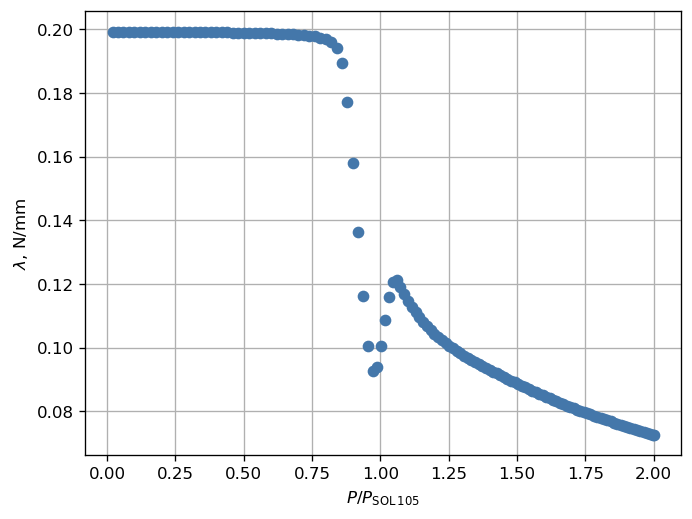

In [16]:
# Read load history from op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + ".op2")
sol_106_op2 = read_op2(op2_filename=op2_filepath, debug=None, load_geometry=True)
_, loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2=sol_106_op2)
load_history = np.concatenate(
    [loads[subcase_id][:, load_component_index] for subcase_id in loads]
)  # concatenate applied load arrays of all subcases

# Read the lowest eigenvalue of KLLRH matrices from f06 file
f06_filepath = os.path.join(
    analysis_directory_path, input_name + ".f06"
)  # path to .f06 file
lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(
    f06_filepath
)

# Create new figure and plot load history vs lowest eigenvalues
_, ax = plt.subplots()
ax.plot(load_history / linear_buckling_load, lowest_eigenvalues[0, :], "o")
plt.xlabel("$P/P_\mathrm{SOL\,105}$")
plt.ylabel("$\lambda$, N/mm")
plt.grid()
plt.show()

We observe that the lowest eigenvalue of the tangent stiffness matrix is initially nearly constant, hence the linear regime, it drops after $P/P_\text{SOL 105}=0.75$, reaches a minimum just before $P/P_\text{SOL 105}=1$, increases just after that, and then it decreases again. We note that the lowest eigenvalue is always positive for the investigated load range and, consequently, the tangent stiffness matrix is always positive definite. This means that our box beam does not encounter any critical point, where the lowest eigenvalue should become null, and it is always in a stable equilibrium. This last result seems to confirm the idea that equilibrium diagram of the box beam under a bending load is characterized by something analogous to a broken supercritical pitchfork rather than a supercritical pitchfork bifurcation.

## Conclusion <a name="conclusion"></a>

***

In this notebook we have verified that SOL 106's nonlinear buckling method predicts a similar buckling load to SOL 105 for an applied load falling in the linear region of the structural response of the box beam. We also noted that the nonlinear buckling load trend predicted by SOL 106 transitions to a linear relation with the applied load as the latter increases above the linear buckling load predicted. In analogy with the behavior of the Euler's column, we have supposed that this may be caused by the break of the supercritical pitchfork bifurcation that characterizes the response of a non-perfectly symmetric problem. In fact, by monitoring the lowest eigenvalue of the tangent stiffness matrix duuring the nonlinear analysis, we have verified that the structure is always stable and does not encounter any critical point, which seems to confirm our hypothesis.

In our [next notebook](07_Verification_of_SOL_106_Nonlinear_Buckling_Method_for_the_Imperfect_Euler_Column.ipynb) we are going to repeat the verification of SOL 106's nonlinear buckling method and of the positive definiteness of the tangent stiffness matrix for the imperfect Euler's column, that is to say an Euler's column with a slight eccentricity in the applied compression load.